In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import datetime

In [4]:
# convert Farenheit to Temperatuer
def F_to_C(f_array):
    # converts array of temperatures in Farenheit to Celsuis
    f_array = np.array(f_array) # make sure it's a numpy array
    c_array = (f_array - 32)*5/9
    return c_array

In [15]:
# grab AWS file with average temperature calculated (15 min resolution)
weather_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/WEATHER/wx_from_crrel_202209/wx_Haenke_2014_2022_nogap.csv',
                        usecols=[5,6,7,8,9])
weather_df.AKDT = pd.to_datetime(weather_df.AKDT) # convert to datetime
weather_df

# Calculate daily/weekly/monthly/mean
daily_df = weather_df.groupby(pd.Grouper(key='AKDT', freq='D')).mean() 
weekly_df = weather_df.groupby(pd.Grouper(key='AKDT', freq='W')).mean() 
monthly_df = weather_df.groupby(pd.Grouper(key='AKDT', freq='M')).mean() 

weekly_df

,Temp-AIR1,Temp-AIR2,Temp-AVG
AKDT,,,
2014-01-01,NaN,NaN,NaN
2014-01-02,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN
2014-01-04,NaN,NaN,NaN
2014-01-05,NaN,NaN,NaN
...,...,...,...
2022-09-18,42.839375,42.048125,42.443750
2022-09-19,42.794375,42.029375,42.411875
2022-09-20,44.020870,43.181522,43.601196


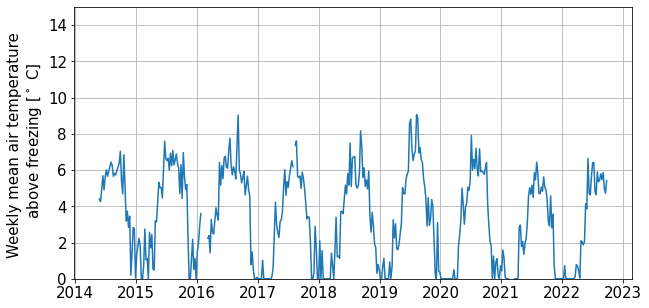

In [59]:
# Correct by elevation using a lapse rate
LAPSE_RATE = -6 # degrees C/K per km
ELEV_MEAN = 200 # m asl
        
corrected_T = F_to_C(weekly_df['Temp-AVG'])+(ELEV_MEAN/1000)*LAPSE_RATE
corrected_T[corrected_T < 0] = 0 # keep only temperatures above freezing
weekly_df['temp_elev_corrected'] = corrected_T # add back into dataframe

# PLOT WEEKLY AIR TEMP:
fs = 15
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(weekly_df.index, corrected_T)
ax.set_ylabel('Weekly mean air temperature \n above freezing [$^\circ$ C]', fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_ylim(0,15)
ax.grid()
plt.show()

/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_16521/3601283132.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_df['annual_PDD'] = annual_PDD


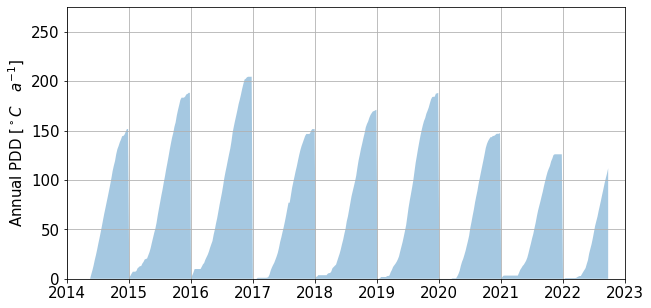

In [60]:
# Calculate annual PDD
years = []
annual_PDDs = []
dfs = []
for year in range(2014,2023):
    # grab annual temperatures
    annual_df = weekly_df[(weekly_df.index.to_pydatetime() > datetime.datetime(year-1,12,31)) &
               (weekly_df.index.to_pydatetime() < datetime.datetime(year+1,1,1))]
    annual_PDD = np.nancumsum(annual_df.temp_elev_corrected) # calculate annual PDD
    annual_df['annual_PDD'] = annual_PDD
    
    # add to lists
    dfs.append(annual_df)
    annual_PDDs.append(annual_PDD)
    years.append(year)

weekly_df = pd.concat(dfs) # recombine

# Plot:
fs = 15
fig, ax = plt.subplots(figsize=(10,5))
ax.fill_between(weekly_df.index, weekly_df.annual_PDD, alpha=0.4)
ax.set_ylabel('Annual PDD [$^\circ C$   $a^{-1}$]', fontsize=fs)
ax.set_ylim(0,275)
# ax.set_title(str(ELEV_MEAN)+' m a.s.l.', fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_xlim(datetime.datetime(2014,1,1), datetime.datetime(2023,1,1))
ax.grid()
plt.show()